## ARCH and GARCH Models

https://github.com/bashtage/arch Package NB

In [1]:
! pip install arch


In [2]:
import arch
from arch import arch_model
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import sys

sys.path.append("/home/jovyan/data_warehouse/")
from dw_src.api.features_api import get_features_df, load_features

### Prep Data

In [3]:
# High Frequency Data
features_to_load = [
    "midprice_mean",
    "traded_price_mean"

]

# Last 2 weeks
end_date = datetime.datetime.now(datetime.timezone.utc)
start_date = end_date - datetime.timedelta(days=7)

# Choose buckketing
time_agg = "60sec" # 1sec/5sec/10sec/30sec/60sec

high_freq= load_features(
    "ftx", "BTCUSDP", time_agg, start_date, end_date, features_to_load
)
high_freq.to_csv("1Min_BTCUSDP_March23_30.csv")

/opt/conda/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Query complete after 0.72s: 100%|██████████| 1/1 [00:00<00:00,  1.39query/s]
/opt/conda/lib/python3.8/site-packages/google/cloud/bigquery/client.py:444: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
Downloading: 100%|██████████| 8833/8833 [00:00<00:00, 18913.15rows/s]


In [4]:
high_freq

,exchange,symbol,midprice_mean,traded_price_mean
timestamp,,,,
2022-03-23 20:47:00+00:00,ftx,BTCUSDP,42358.945381,42361.200000
2022-03-23 20:48:00+00:00,ftx,BTCUSDP,42359.173188,42357.486486
2022-03-23 20:49:00+00:00,ftx,BTCUSDP,42378.913550,42375.818182
2022-03-23 20:50:00+00:00,ftx,BTCUSDP,42363.189870,42363.264901
2022-03-23 20:51:00+00:00,ftx,BTCUSDP,42332.936883,42330.193396
...,...,...,...,...
2022-03-29 23:55:00+00:00,ftx,BTCUSDP,47509.069554,47507.727811
2022-03-29 23:56:00+00:00,ftx,BTCUSDP,47495.138889,47495.434397
2022-03-29 23:57:00+00:00,ftx,BTCUSDP,47485.760173,47485.397799


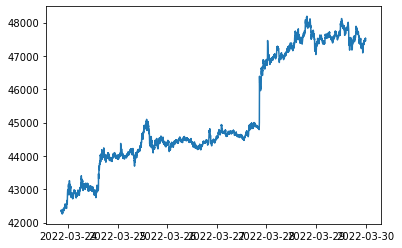

In [5]:
plt.plot(high_freq['midprice_mean'])

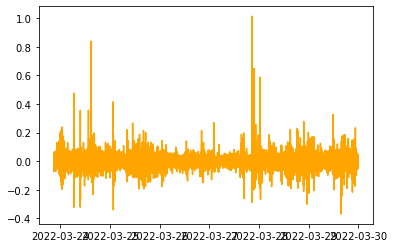

In [7]:
plt.plot(100 * high_freq['midprice_mean'].pct_change().dropna(),color='orange')

In [74]:
returns = 10000 * high_freq['midprice_mean'].pct_change().dropna() # scaling for MLE Convergence 
am = arch_model(returns, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:          midprice_mean   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -25532.9
Distribution:                  Normal   AIC:                           51075.8
Method:            Maximum Likelihood   BIC:                           51111.2
                                        No. Observations:                 8842
Date:                Wed, Mar 30 2022   Df Residuals:                     8841
Time:                        20:38:40   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0598  4.185e-02      1.430      0.153 [-2.21

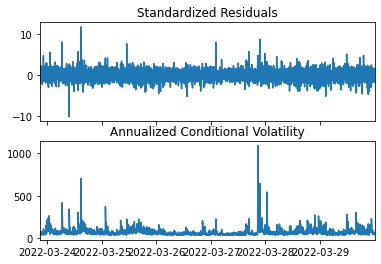

In [75]:
fig = res.plot(annualize="D")

### Mean Models


In [76]:
from arch.univariate import ARX

ar = ARX( high_freq['midprice_mean'], lags=[1, 3, 12])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:          midprice_mean   R-squared:                       1.000
Mean Model:                        AR   Adj. R-squared:                  1.000
Vol Model:          Constant Variance   Log-Likelihood:               -40525.8
Distribution:                  Normal   AIC:                           81061.7
Method:            Maximum Likelihood   BIC:                           81097.1
                                        No. Observations:                 8831
Date:                Wed, Mar 30 2022   Df Residuals:                     8827
Time:                        20:38:49   Df Model:                            4
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const              8.7943      7.137      1

### Volatility Processes

In [77]:
from arch.univariate import ARCH, GARCH

ar.volatility = ARCH(p=5)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - ARCH Model Results                            
Dep. Variable:          midprice_mean   R-squared:                       1.000
Mean Model:                        AR   Adj. R-squared:                  1.000
Vol Model:                       ARCH   Log-Likelihood:               -38899.6
Distribution:                  Normal   AIC:                           77819.2
Method:            Maximum Likelihood   BIC:                           77890.1
                                        No. Observations:                 8831
Date:                Wed, Mar 30 2022   Df Residuals:                     8827
Time:                        20:39:22   Df Model:                            4
                                    Mean Model                                    
                     coef    std err          t      P>|t|        95.0% Conf. Int.
----------------------------------------------------------------------------------
Const              5.0540      7.857    

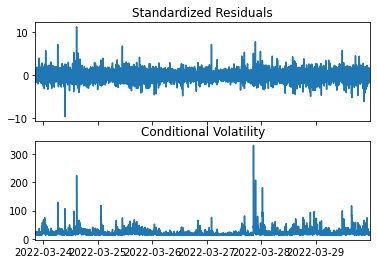

In [78]:
fig = res.plot()